In [1]:
import os
import re
import h5py
import struct
import numpy as np
import configparser
import matplotlib.pyplot as plt

In [2]:
config = configparser.ConfigParser()
config.read('file_paths.ini')
config.sections()

['MAIN_DATA_PATH', 'FY3', 'HIMAWARI']

In [3]:
# File paths for FengYun-3E data.
FY3E_DATA_FOLDERS_LOCATION = config['FY3']['FY3E_MAIN_DATA_LOCATION']
FY3E_RAW_DATA_LOCATION = config['FY3']['FY3E_RAW_DATA_LOCATION']
FY3E_L0_DATA_LOCATION = config['FY3']['FY3E_L0_DATA_LOCATION']
FY3E_L1_DATA_LOCATION = config['FY3']['FY3E_L1_DATA_LOCATION']
FY3E_L1_GOE_DATA_LOCATION = config['FY3']['FY3E_L1_GOE_DATA_LOCATION']
FY3E_L1_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_IMAGE_DATA_LOCATION']
FY3E_L1_GEOREF_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_GEOREF_IMAGE_DATA_LOCATION']

In [4]:
fy3e_L0_files_paths = [FY3E_L0_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L0_DATA_LOCATION)]
fy3e_l1_geo_files_paths = [FY3E_L1_GOE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_GOE_DATA_LOCATION)]
fy3e_l1_image_files_paths = [FY3E_L1_IMAGE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_IMAGE_DATA_LOCATION)]

print('L0 files -', fy3e_L0_files_paths)
print()
print('GEO files -', fy3e_l1_geo_files_paths)
print()
print('Image files -', fy3e_l1_image_files_paths)

L0 files - ['E:/Satellite data/FY-3E/L0/Y3E_08534_230226070855_7860R_MERSI.DAT']

GEO files - ['E:/Satellite data/FY-3E/L1/geo/FY3E_MERSI_GRAN_L1_20230228_2215_GEOQK_V0.HDF']

Image files - ['E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230228_2215_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20240301_0915_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0435_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0935_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0520_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0840_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0845_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1020_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1745_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_2100_0250

In [5]:
def find_synchroseries(byte_line: bytes) -> np.array:
    synchroseries = b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d'
    return np.array([i.start() for i in re.finditer(synchroseries, byte_line)])

In [6]:
def read_uint12(data_chunk):
    data = np.frombuffer(data_chunk, dtype=np.uint8)
    fst_uint8, mid_uint8, lst_uint8 = np.reshape(data, (data.shape[0] // 3, 3)).astype(np.uint16).T
    fst_uint12 = (fst_uint8 << 4) + (mid_uint8 >> 4)
    snd_uint12 = ((mid_uint8 % 16) << 8) + lst_uint8
    return np.reshape(np.concatenate((fst_uint12[:, None], snd_uint12[:, None]), axis=1), 2 * fst_uint12.shape[0])

In [7]:
l0_data = open(fy3e_L0_files_paths[0], 'br')

In [8]:
header_size = 1331906 - 119938 - 52424
header_size

1159544

In [9]:
data = l0_data.read(header_size)

In [10]:
section_1, section_2 = [], []
section_3, section_4, section_5, section_6, section_7 = [], [], [], [], []

data1_agg, data2_agg, data3_agg, data4_agg = [], [], [], []

hyperX_data_agg = []

for _ in range(500):
    data1 = l0_data.read(554)
    data1_agg.append(data1)

    data2 = l0_data.read(25930)
    data2_agg.append(data2)

    data3 = l0_data.read(17290)
    data3_agg.append(data3)

    data4 = l0_data.read(8650)
    data4_agg.append(data4)
    
    for i in range(40):
        data = l0_data.read(9226)
        section_1.append(read_uint12(data[10:]))

    for i in range(40):
        data = l0_data.read(9226)
        section_2.append(read_uint12(data[10:]))
        
    for i in range(40):
        data = l0_data.read(9226)
        
        section_3.append(read_uint12(data[10:2314]))
        section_4.append(read_uint12(data[2314:4618]))
        section_5.append(read_uint12(data[4618:6922]))
        section_6.append(read_uint12(data[6922:9226]))


section_1 = np.array(section_1)
section_2 = np.array(section_2)
section_3 = np.array(section_3)
section_4 = np.array(section_4)
section_5 = np.array(section_5)
section_6 = np.array(section_6)

### Space view data

In [11]:
data3 = np.array(data2_agg)

In [49]:
data3[:3]

array([b'',
       b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d\x060n\x06\xe0`\x06\xf0g\x06\xe0g\x06\xf0_\x06\xb0e\x06\xa0i\x06`l\x06\x90k\x06\x80k\x06`p\x05\xe0d\x06\xc0f\x07\x00e\x06\xf0]\x06@d\x06`g\x07\x00h\x06@m\x06\x90m\x06\xe0f\x06`l\x06@b\x06Ps\x06@e\x06\xb0h\x06@g\x06pg\x06\xc0j\x06`d\x06po\x06\xd0i\x06\xc0g\x06\xc0k\x06\xa0f\x06\xd0e\x06\xf0n\x06\x80^\x06\x90h\x06\xb0e\x06\xb0p\x06\xb0i\x06\xa0f\x06 b\x06\xa0n\x06`i\x060m\x07\x00g\x06`h\x06\xa0a\x06\x10j\x06\x90f\x06\xe0i\x06@s\x06\x90o\x05\xb0g\x06\xd0v\x06\xf0]\x06pe\x060i\x060k\x06\xd0h\x06\xb0i\x06pk\x06\xe0h\x06Pi\x06\xd0q\x06\x90g\x07\x00l\x07 o\x07\x00o\x07@h\t\x10\x97\tP\x96\x08\xc0\x90\x08\xf0\x9c\t \x99\tP\x92\x08\xe0\x94\t\xb0\x93\x08\xe0\x8f\tp\x99\t\x90\x88\t \x98\t@\x99\t\xd0\x99\t@\x8b\t0\x8c\t`\x90\t`\x96\t\xb0\x8d\t\xf0\x8b\t\x80\x9e\t \x93\x08\xe0\x97\t\xd0\x90\t\xc0\x93\t \x93\t\x80\x91\tP\x9b\t\x10\x96\tP\x90\tP\x9c\t\x80\x96\t \x92\t \x93\t@\x94\t\xa0\x96\t\x80\x9b\tP\x95\t\xc0\x95\x08\xe0\x95\t`\x8f\x08\xf0\x

In [12]:
sv_block_size = 216

In [15]:
for i in data3:
    if len(i) != 25930:
        print(i)
        

b''
b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d\x07 p\x06\xb0i\x07 i\x07 o\x070q\x06\xa0m\x06\xb0`\x07\x00m\x06pm\x06\x90j\x07\x10f\x06\xd0h\x07Pr\x06\xb0p\x06\xa0g\x07Pk\x06\xb0l\x06\xa0o\x06\xa0e\x06\x80f\x06\xc0q\x06\xa0o\x06@k\x06\xc0n\x06\x80j\x060u\x06\xc0n\x06\xe0g\x06\xa0o\x06\x80i\x06Pn\x06\xf0d\x07`o\x06\x90q\x06\xc0i\x06@q\x07 n\x06\xe0h\x06\xd0k\x06\xf0d\x07 q\x06\xd0i\x06Pn\x06\xb0c\x07ph\x06\xe0m\x06\x80h\x06\xa0f\x06\xc0o\x06\xe0q\x07\x00g\x07\x10l\x07\x00i\x07\x10a\x06pl\x07Pr\x06\xa0q\x06`l\x06\xb0o\x06\xc0j\x07\x00m\x07Pp\x06\xf0w\x06\xd0j\x06\x80f\x06\xa0q\x06pm\x06\xa0f\x06Pf\x06pm\x060n\x06\xf0f\t\x80\x94\t\xf0\x9e\t`\x93\t\x90\x96\tP\xa0\tP\x96\t\xb0\x9f\t`\x95\t`\x96\t`\x91\n\x10\x9d\t\xa0\x97\t\x10\x9a\t\x80\x96\n0\x99\t\xb0\x9b\t\x80\x92\t\x80\x9f\t`\x98\t\x80\x94\tP\x93\n\x00\x97\t\xc0\x98\n\x10\xa1\n \xa3\n\x00\xa3\n\x00\x96\t`\x9a\t\x80\x9e\n\x10\x9a\t\x80\x9c\n\x00\x99\t\xb0\x9a\t\x90\x9b\n0\xa1\t\xa0\x9b\t\xd0\x8e\t\xf0\x9a\x08\xe0\x95\t@\x9f\t\xe0\x9b\t\xa0\x

In [13]:
sv_b6_data = []
sv_b7_data = []
sv_1km_data = []
for i, sv_block_all in enumerate(data3):
    sv_block_all_no_synh = sv_block_all[10:]
    
    sv_blocks = []
    for block_index in range(0, 25920, sv_block_size):
        try:
            sv_blocks.append(read_uint12(sv_block_all_no_synh[block_index:block_index + sv_block_size]))
        except:
            print(i)

    sv_blocks = np.array(sv_blocks)

    sv_b6_data.append(sv_blocks[:40])
    sv_b7_data.append(sv_blocks[40:80])
    sv_1km_data.append(sv_blocks[80:120])

167
365


In [24]:
sv_data_by_scan_line = []
for i in sv_b6_data:
    for j in i:
        if len(j) == 144:
            sv_data_by_scan_line.append(j)

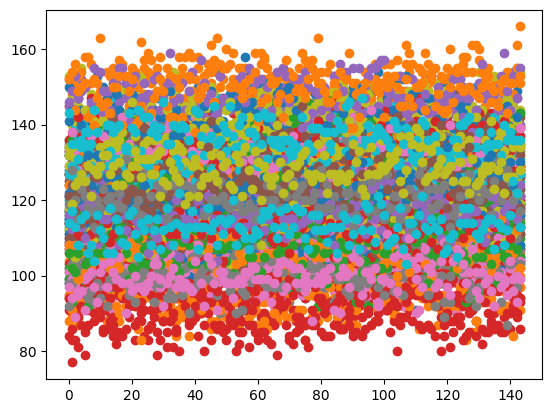

In [32]:
for i in sv_data_by_scan_line[:100]:
    plt.scatter(np.arange(144), i)
    #print(i)
    #break

In [45]:
x = np.vstack(sv_data_by_scan_line[:2])

np.linalg.inv(x.T.dot(x)).dot(x.T).dot(np.mean(x, axis=1))

# a, b = np.polyfit(np.arange(144), y, 1)
# poly1d_fn = np.poly1d((a, b))
# plt.plot(np.arange(144), y, 'yo', np.arange(144), poly1d_fn(y), '--k')

LinAlgError: Singular matrix

In [40]:
np.vstack(sv_data_by_scan_line[:2])

array([[ 99, 110, 110,  96, 111, 103, 110, 103, 111,  95, 107, 101, 106,
        105, 102, 108, 105, 107, 104, 107, 102, 112,  94, 100, 108, 102,
        112, 101, 111,  93, 100, 100, 102, 103, 112, 104, 100, 109, 105,
        109, 110, 102, 102, 108, 100,  98, 101, 115, 100, 101, 107, 104,
        100, 103, 103, 103, 108, 106, 102, 100, 103, 111, 109, 105, 108,
        103, 108, 107, 106, 102, 109, 101, 111, 110, 104,  94, 105, 104,
        107, 101, 107, 112, 107, 105, 106, 102,  98,  98, 106, 110, 102,
        105,  99, 109, 112, 103, 102, 104, 106,  97,  97, 106, 105, 102,
        110, 105, 100, 115, 105, 111,  91, 103, 109, 118, 111,  93, 103,
        101,  99, 105,  99, 107, 109, 104, 107, 105, 103, 107, 110, 104,
        101, 105, 109, 113, 105, 103, 112, 108, 114, 111, 112, 111, 116,
        104],
       [145, 151, 149, 150, 140, 144, 143, 156, 146, 153, 149, 146, 142,
        148, 155, 147, 142, 143, 151, 153, 153, 136, 146, 152, 148, 153,
        157, 153, 148, 139, 147, 140,

110

In [14]:
test_data3 = data3[1][10:]

In [15]:
sv_block_size = 216

In [16]:
sv_blocks = []
for block_index in range(0, 25920, sv_block_size):
    sv_blocks.append(read_uint12(test_data3[block_index:block_index + sv_block_size]))

sv_blocks = np.array(sv_blocks)

In [17]:
sv_blocks.shape

(120, 144)

In [18]:
sv_blocks[0]

array([ 99, 110, 110,  96, 111, 103, 110, 103, 111,  95, 107, 101, 106,
       105, 102, 108, 105, 107, 104, 107, 102, 112,  94, 100, 108, 102,
       112, 101, 111,  93, 100, 100, 102, 103, 112, 104, 100, 109, 105,
       109, 110, 102, 102, 108, 100,  98, 101, 115, 100, 101, 107, 104,
       100, 103, 103, 103, 108, 106, 102, 100, 103, 111, 109, 105, 108,
       103, 108, 107, 106, 102, 109, 101, 111, 110, 104,  94, 105, 104,
       107, 101, 107, 112, 107, 105, 106, 102,  98,  98, 106, 110, 102,
       105,  99, 109, 112, 103, 102, 104, 106,  97,  97, 106, 105, 102,
       110, 105, 100, 115, 105, 111,  91, 103, 109, 118, 111,  93, 103,
       101,  99, 105,  99, 107, 109, 104, 107, 105, 103, 107, 110, 104,
       101, 105, 109, 113, 105, 103, 112, 108, 114, 111, 112, 111, 116,
       104], dtype=uint16)

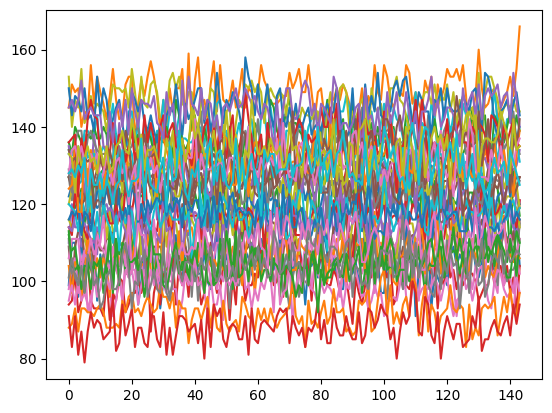

In [20]:
for i in range(40):
    plt.plot(np.arange(sv_blocks.shape[1]), sv_blocks[i])

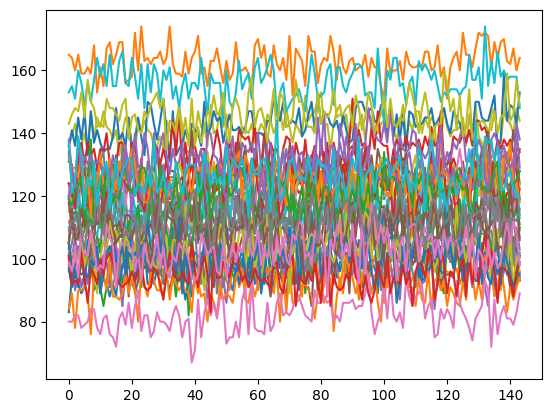

In [150]:
for i in range(40):
    plt.plot(np.arange(sv_blocks.shape[1]), sv_blocks[40 + i])

In [ ]:
for index, i in enumerate(sv_blocks[80:120]):
    

In [23]:
sv_blocks[80:120]

array([[ 200,  203,  199, ...,  181,  185,  185],
       [ 184,  187,  185, ...,  242,  241,  242],
       [ 173,  174,  173, ...,  146,  148,  146],
       ...,
       [2027, 2030, 2032, ..., 2069, 2045, 2055],
       [1960, 1976, 1989, ..., 2039, 2091, 2062],
       [1913, 1916, 1910, ..., 1962, 1962, 1973]], dtype=uint16)

In [205]:
sv_blocks[97:98][0][72:108]

array([1933, 1900, 1923, 1899, 1925, 1914, 1925, 1911, 1905, 1905, 1922,
       1931, 1935, 1943, 1922, 1939, 1954, 1937, 1942, 1953, 1952, 1955,
       1946, 1965, 1947, 1962, 1970, 1999, 1982, 1935, 1978, 1982, 1978,
       1973, 1991, 1984], dtype=uint16)

In [40]:
test_data4 = data3_agg[1][10:]

In [41]:
voc_block_size = 144

In [42]:
voc_blocks = []
for block_index in range(0, 17280, voc_block_size):
    voc_blocks.append(read_uint12(test_data4[block_index:block_index + voc_block_size]))

voc_blocks = np.array(voc_blocks)

In [43]:
voc_blocks.shape

(120, 96)

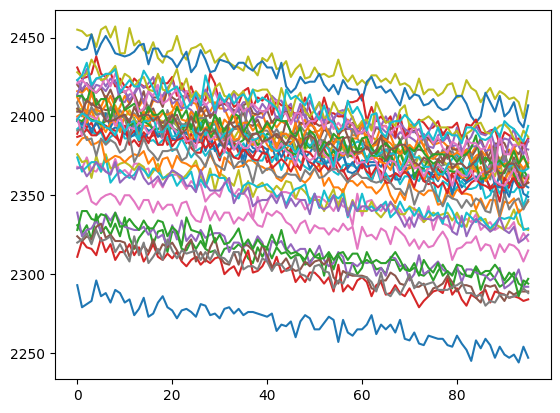

In [22]:
for i in range(40):
    plt.plot(np.arange(voc_blocks.shape[1]), voc_blocks[i])

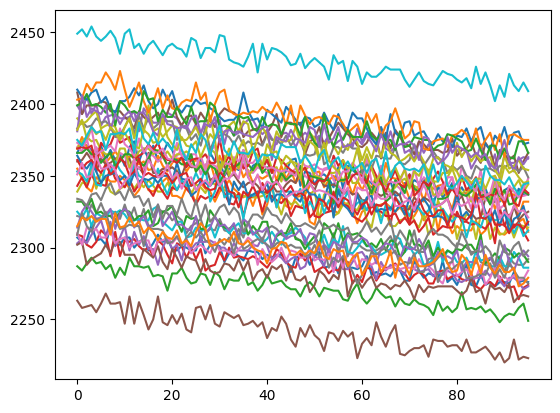

In [23]:
for i in range(40):
    plt.plot(np.arange(voc_blocks.shape[1]), voc_blocks[40 + i])

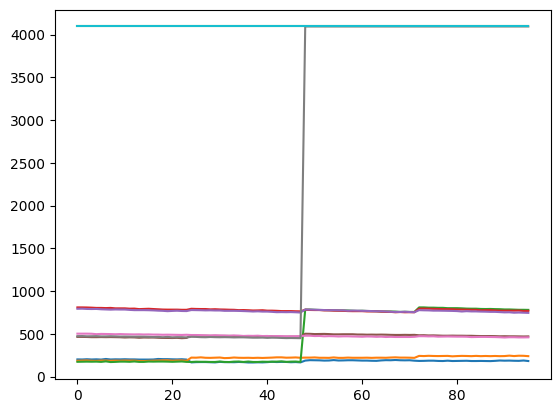

In [25]:
for i in range(10):
    plt.plot(np.arange(voc_blocks.shape[1]), voc_blocks[80 + i])

In [25]:
test_data5 = data4_agg[1][10:]

In [26]:
bb_block_size = 72

In [27]:
bb_blocks = []
for block_index in range(0, 8640, bb_block_size):
    bb_blocks.append(read_uint12(test_data5[block_index:block_index + bb_block_size]))

bb_blocks = np.array(bb_blocks)

In [28]:
bb_blocks.shape

(120, 48)

Найти среднее и станлартное отклонение

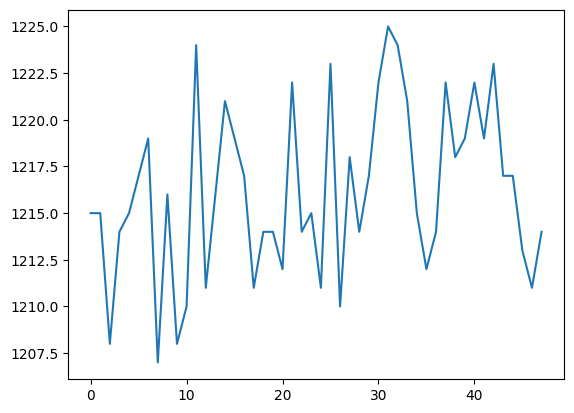

In [30]:
for i in range(1):
    plt.plot(np.arange(bb_blocks.shape[1]), bb_blocks[i])

In [34]:
np.mean(bb_blocks[0])

1216.1458333333333

In [46]:
np.std(bb_blocks[0])

4.573426793870094

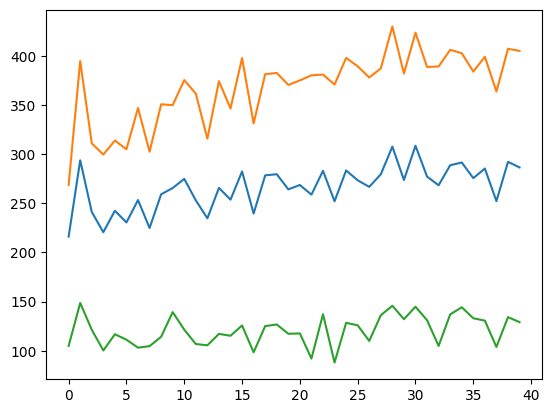

In [47]:
plt.plot(np.arange(40), np.mean(bb_blocks[:40], axis=1) - 1000)
plt.plot(np.arange(40), np.mean(voc_blocks[:40], axis=1) - 2000)
plt.plot(np.arange(40), np.mean(sv_blocks[:40], axis=1))

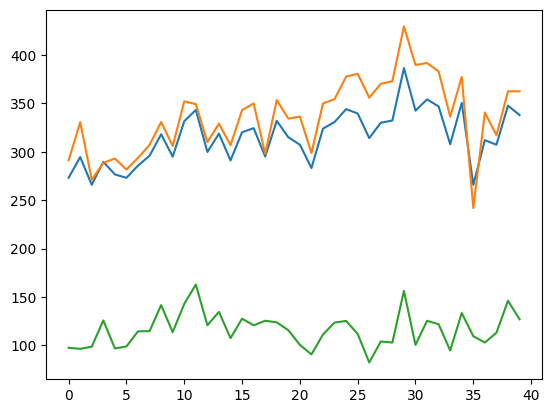

In [48]:
plt.plot(np.arange(40), np.mean(bb_blocks[40:80], axis=1) - 1000)
plt.plot(np.arange(40), np.mean(voc_blocks[40:80], axis=1) - 2000)
plt.plot(np.arange(40), np.mean(sv_blocks[40:80], axis=1))

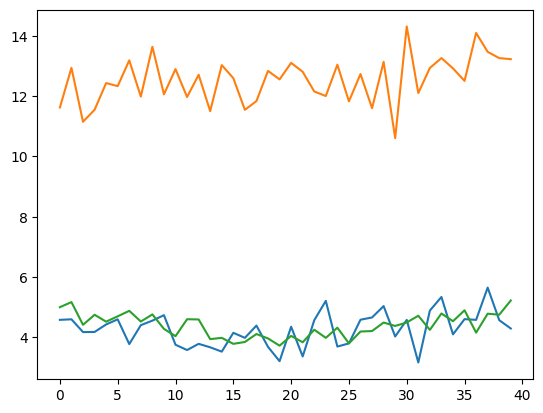

In [45]:
plt.plot(np.arange(40), np.std(bb_blocks[:40], axis=1))
plt.plot(np.arange(40), np.std(voc_blocks[:40], axis=1))
plt.plot(np.arange(40), np.std(sv_blocks[:40], axis=1))

In [35]:
np.std(bb_blocks[0])

4.573426793870094